# Model training for arabic character recognition app

## 1. Librairies and data

To make the code work, you need to download the data (csvTrain and csvTest images and labels) here :  https://www.kaggle.com/datasets/mloey1/ahcd1/data?select=Train%2BTest+Images+Matlab.mat

Then, import it in a folder named "data.  We can now load the librairies we need for this project.



In [12]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, metrics
import joblib
import pandas as pd
import cv2

#Deep learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

We cann now load the arabic letters datasets:

In [13]:
#Train dataset
X_train = pd.read_csv("data/csvTrainImages 13440x1024.csv")
y_train = pd.read_csv("data/csvTrainLabel 13440x1.csv")
y_train = y_train -1 #labels start from 0

#Test dataset
X_test = pd.read_csv("data/csvTestImages 3360x1024.csv")
y_test = pd.read_csv("data/csvTestLabel 3360x1.csv")
y_test = y_test -1 

The following code plot an exemple of the training data. You can change the number "30" by any number between 0 and 13438.

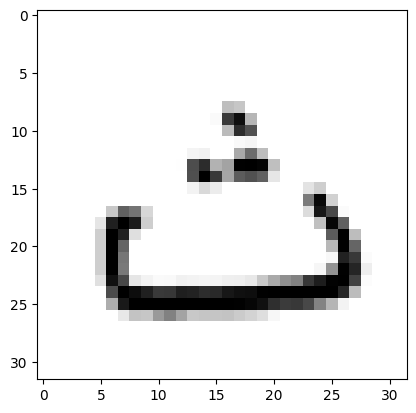

In [14]:

image_ex = np.array(X_train)[30].reshape(32, 32)
#reverse each column
image_ex= image_ex.T #to get the character as it is read

plt.imshow(image_ex, cmap='binary')

## 2. Data preparation and model architecture

Since the data set comes directly from kaggle, it is already clean (no duplicates or incomplete data) and ready to be use for training.

In [15]:
# Preprocess the data for deep learning
X_train_DL = np.array(X_train).reshape((X_train.shape[0], 32, 32, 1))
X_test_DL = np.array(X_test).reshape((X_test.shape[0], 32, 32, 1))
X_train_DL = X_train_DL.astype('float32') / 255
X_test_DL = X_test_DL.astype('float32') / 255

# Convert labels to categorical for compatibility with Keras
num_classes = 28
y_train_DL = to_categorical(y_train, num_classes)
y_test_cat_DL = to_categorical(y_test, num_classes)

The chosen model architecture is a Convolutional Neural Network (CNN) designed for image classification tasks (32x32 grayscale images).The model consists of three convolutional layers, each followed by max pooling, then a flatten layer, a dense layer with dropout for regularization, and finally an output layer. The use of ReLU activation and He uniform initialization in the convolutional and dense layers helps in training deep networks effectively.

In [16]:
# Define the CNN model architecture

model = Sequential([
    # First Convolutional Layer
    # 32 filters, 3x3 kernel size, ReLU activation, He uniform initialization
    # Input shape: 32x32 grayscale images (1 channel)
    Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(32, 32, 1)),
    
    # Max Pooling Layer
    # Reduces spatial dimensions by half
    MaxPooling2D((2, 2)),
    
    # Second Convolutional Layer
    # 64 filters, 3x3 kernel size, ReLU activation, He uniform initialization
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'),
    
    # Max Pooling Layer
    MaxPooling2D((2, 2)),
    
    # Third Convolutional Layer
    # 64 filters, 3x3 kernel size, ReLU activation, He uniform initialization
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'),
    
    # Flatten Layer
    # Converts the 2D feature maps to a 1D vector
    Flatten(),
    
    # First Dense Layer
    # 128 neurons, ReLU activation, He uniform initialization
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    
    # Dropout Layer
    # Helps prevent overfitting by randomly setting 50% of inputs to 0
    Dropout(0.5),
    
    # Output Layer
    # Number of neurons equals number of classes, Softmax activation for multi-class classification
    Dense(num_classes, activation='softmax')
])


/home/fhakym/Documents/Github_projects/Arabic_letters_quizz_streamlit/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 3. Model training and save

The given code compiles, trains, and evaluates a neural network model:

1. **Compile**: Uses the Adam optimizer with a learning rate of 0.001 and categorical crossentropy loss.
2. **Summary**: Displays the model architecture and parameters.
3. **Train**: Fits the model on training data for 20 epochs with a batch size of 32, using 10% of the data for validation.
4. **Evaluate**: Assesses model performance on test data and prints the test accuracy.


This process prepares the model for training and measures its effectiveness on unseen data. The proposed hyperparameters are standard, but could be optimized for better results.

In [17]:
# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

# Train the model
history = model.fit(X_train_DL, y_train_DL, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test_DL, y_test_cat_DL, verbose=0)
print(f'Test accuracy: {test_accuracy:.4f}')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 28)             │         3,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 190,556 (744.36 KB)

 Trainable params: 190,556 (744.36 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.2259 - loss: 2.6483 - val_accuracy: 0.7165 - val_loss: 0.8634
Epoch 2/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.6836 - loss: 0.9500 - val_accuracy: 0.7894 - val_loss: 0.5758
Epoch 3/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - accuracy: 0.7960 - loss: 0.5997 - val_accuracy: 0.8601 - val_loss: 0.3962
Epoch 4/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.8541 - loss: 0.4303 - val_accuracy: 0.8765 - val_loss: 0.3509
Epoch 5/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.8954 - loss: 0.3242 - val_accuracy: 0.8743 - val_loss: 0.3684
Epoch 6/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.9117 - loss: 0.2651 - val_accuracy: 0.8929 - val_loss: 0.3356
Epoch 7/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.9262 - loss: 0.2304 - val_accuracy: 0.8943 - val_loss: 0.3373
Epoch 8/20
378/378 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9289 - loss: 0.2021 - 

We then save the obtained model.

In [18]:
# Save the model
model.save('app/cnn_model.keras')

## 4. Model loading, evaluation, and test with visualisation on a image prediction

In [19]:
model = tf.keras.models.load_model('app/cnn_model.keras')

In [20]:
# Make predictions on test data
y_pred_DL = model.predict(X_test_DL)
y_pred_classes_DL = np.argmax(y_pred_DL, axis=1)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test_DL, y_test_cat_DL, verbose=0)
print(f'Test accuracy: {test_accuracy:.4f}')

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Test accuracy: 0.9425


Test prediction on a single image. You can replace the '3' by any number to test on a different image.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2


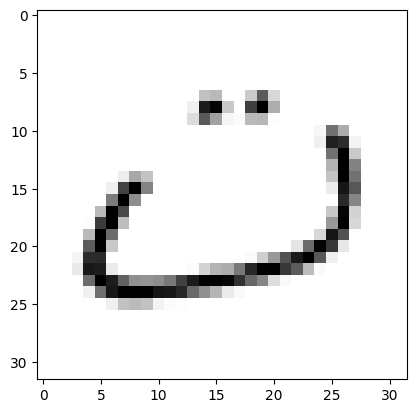

In [21]:
image_test = np.array(X_test)[3].reshape(32, 32, 1)
image_test = image_test.astype('float32') / 255

# Make predictions on the test image
y_pred_DL = model.predict(image_test.reshape(1, 32, 32, 1))
y_pred_classes_DL = np.argmax(y_pred_DL, axis=1)
print(y_pred_classes_DL[0])

# Plot the image
import matplotlib.pyplot as plt
image_test = image_test.T
plt.imshow(image_test.reshape(32, 32), cmap='binary')
plt.show()
